In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 14 15:21:58 2024

@author: Manfred Brath

Example script to demonstrate the usage of the flux_simulator_module for generating lookuptables.

"""
# %%
import numpy as np
import matplotlib.pyplot as plt
import FluxSimulator as fsm
from pyarts.plots import arts_lookup
from pyarts import arts

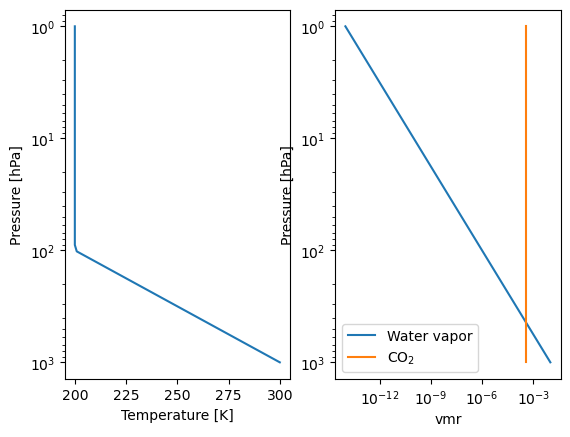

In [2]:
# This atmosphere is not intended to be fully realistic, but to be simply
# an example for the calculation of LUT.

# set pressure grid
pressure_profile = np.linspace(1000e2, 1e2, 80)

# create water vapor profile
# Water vapor is simply define by a 1st order
# polynomial in log-log space
# log h2o = a + b * log pressure
b = 4
a = -6 - b * 4
logH2O = a + b * np.log10(pressure_profile)
H2O_profile = 10**logH2O

# create temperature profile
# Temperature is simply define by a 1st order
# polynomial of log pressure
# T = a + b * log pressure
# For pressure < 100 hPa, the temperature is set to 200 K
b = 100
a = 200 - b * 4
temperature_profile = a + b * np.log10(pressure_profile)
temperature_profile[pressure_profile < 100e2] = (
    200  # set temperature to 200 K below 100 hPa
)

# CO2 vmr value
CO2 = 400e-6  # [vmr]

# set vmr_field
vmr = np.zeros((2, len(pressure_profile), 1, 1))
vmr[0, :, 0, 0] = H2O_profile
vmr[1, :, 0, 0] = CO2

# plot atmosphere profiles
fig, ax = plt.subplots(1, 2)
ax[0].semilogy(temperature_profile, pressure_profile / 100, label="Temperature")
ax[0].set_xlabel("Temperature [K]")
ax[0].set_ylabel("Pressure [hPa]")
ax[0].invert_yaxis()

ax[1].loglog(H2O_profile, pressure_profile / 100, label="Water vapor")
ax[1].loglog(vmr[1, :, 0, 0], pressure_profile / 100, label="CO$_2$")
ax[1].set_xlabel("vmr")
ax[1].set_ylabel("Pressure [hPa]")
ax[1].invert_yaxis()
ax[1].legend()

...using stored LUT



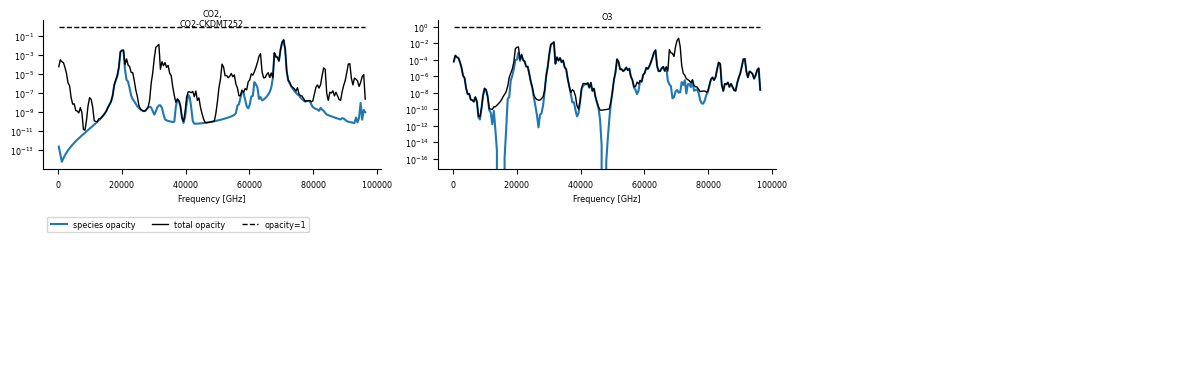

In [3]:
# set frequency grid
min_wvn = 10
max_wvn = 3210
n_freq_lw = 200
wvn = np.linspace(min_wvn, max_wvn, n_freq_lw)
f_grid_lw = arts.convert.kaycm2freq(wvn)


# setup ARTS
flux_simulator_LUT = fsm.FluxSimulator("TESTLUT_SW")
flux_simulator_LUT.ws.f_grid = f_grid_lw
flux_simulator_LUT.set_species(
    ["CO2,CO2-CKDMT252","O3"]
)


# Wide LUT
flux_simulator_LUT.get_lookuptableWide(recalc=False)
LUT = flux_simulator_LUT.ws.abs_lookup.value


# plot
arts_lookup.plot_arts_lookup(LUT)

plt.show()

In [4]:
np.shape(LUT.xsec)

(12, 2, 200, 12)

original: (3, 1, 0.5)
fitted: [3.00076759 1.00471362 0.49947123]


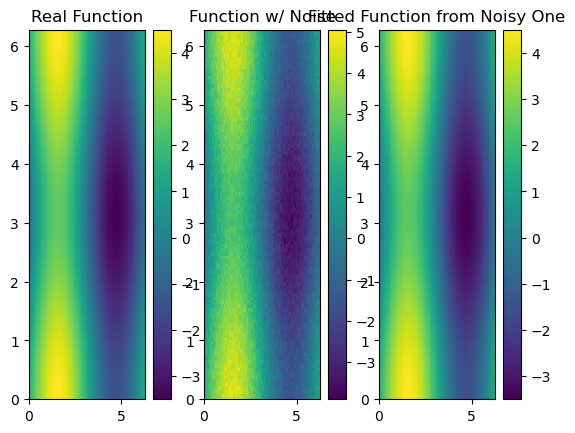

In [5]:
#just try out how curvefit works with a copied example for a noisy 2 dimenaionL function from the internet 

# curvefit with non linear least squares (curve_fit function)
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(x[0])+b*np.cos(x[1])+c

limits = [0, 2*np.pi, 0, 2*np.pi]  # [x1_min, x1_max, x2_min, x2_max]
side_x = np.linspace(limits[0], limits[1], 100)
side_y = np.linspace(limits[2], limits[3], 100)
X1, X2 = np.meshgrid(side_x, side_y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))

xdata = np.vstack((x1_1d, x2_1d))
original = (3, 1, 0.5)
z = func(xdata, *original)
Z = z.reshape(size)
z_noise = z + .2*np.random.randn(len(z))
Z_noise = z_noise.reshape(size)

ydata = z_noise
popt, pcov = curve_fit(func, xdata, ydata)
print("original: {}\nfitted: {}".format(original, popt))
z_fit = func(xdata, *popt)
Z_fit = z_fit.reshape(size)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.title("Real Function")
plt.pcolormesh(X1, X2, Z)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Function w/ Noise")
plt.pcolormesh(X1, X2, Z_noise)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Fitted Function from Noisy One")
plt.pcolormesh(X1, X2, Z_fit)
plt.axis(limits)
plt.colorbar()
plt.savefig('bild.png')
